Git Repository to download the model: https://github.com/krishnamurthy-a/Titanic-Survival-Prediction.git

# Learning basic ML model training concepts by solving Titanic Survival Prediction problem

### About the Problem:
    Using the machine learning tools, we need to analyze the information about the passensgers of RMS Titanic and predict which passenger has survived. This problem has been published by Kaggle and is widely used for learning basic concepts of Machine Learning

### About the data sets

#### Data Dictionary

- Age: Age
- Cabin: Cabin
- Embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- Fare: Passenger Fare
- Name: Name
- Parch: Number of Parents/Children Aboard
- Pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- Sex: Sex
- Sibsp: Number of Siblings/Spouses Aboard
- Survived: Survival (0 = No; 1 = Yes)
- Ticket: Ticket Number

#### Variable Notes

- pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

#### Download location
training data location ->  "https://www.kaggle.com/c/titanic/download/train.csv" <br>
test data location -> "https://www.kaggle.com/c/titanic/download/test.csv"

### 1.0 Load data sets

In [3]:
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_366a081119f849e6862e88812b3ed98f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='k0nEqGfb_IxLkXnE1WOFkiQsLFZ-aVYpkGeJW-66PELy',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_366a081119f849e6862e88812b3ed98f.get_object(Bucket='titanicsurvivalpredictionf8684a7b97d94dde9b87f6e498cf1eb0',Key='train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

training_df = pd.read_csv(body)
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
body = client_366a081119f849e6862e88812b3ed98f.get_object(Bucket='titanicsurvivalpredictionf8684a7b97d94dde9b87f6e498cf1eb0',Key='test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_df = pd.read_csv(body)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Combine the training and test data set so that we can perform data transformations on both these sets in a single attempt. Once the data transformation is complete, the data sets have be segregated back to training and test datasets with out any mix up of samples between the data sets

In [5]:
test_df['Survived'] = 0
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [6]:
complete_data_df = training_df.append(test_df, ignore_index=True)
complete_data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [7]:
print("No. of Training Data samples: " + str(training_df.shape[0]))
print("No. of Test Data samples: " + str(test_df.shape[0]))
print("Complete Data samples: " + str(complete_data_df.shape[0]))

No. of Training Data samples: 891
No. of Test Data samples: 418
Complete Data samples: 1309


### 2.0 Data Pre-processing

##### 2.1 Handle Missing Data

Check for missing values in the columns 

In [8]:
complete_data_df.isnull().sum()
training_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Around 80% of Cabin's data is missing. So it will not be of much use to train the model. 

Let us replace the missing values for age with median. Though not a best approach to replace missing data, we shall use this method for sake of simplicity.

In [9]:
complete_data_df['Age'] = complete_data_df['Age'].fillna(complete_data_df['Age'].median())

Replace missing data for Embarked. Let us use the port where maximum passengers have boarded

In [10]:
complete_data_df.Embarked.value_counts()


S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [11]:
complete_data_df['Embarked'] = complete_data_df['Embarked'].fillna('S')
complete_data_df.Embarked.unique()


array(['S', 'C', 'Q'], dtype=object)

##### 2.2 Encode categorical feature columns

Encode the values of the categorical columns -- Sex, Embarked

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
def encode_features(data_set, feature_names):
    for feature_name in feature_names:
        le = LabelEncoder()
        le.fit(data_set[feature_name])
        encoded_column = le.transform(data_set[feature_name])
        data_set[feature_name] = encoded_column
    return data_set    

In [14]:
features_to_encode = ['Sex', 'Embarked']
complete_data_df = encode_features(complete_data_df, features_to_encode)
complete_data_df.head(10)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0,A/5 21171
1,38.0,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1,PC 17599
2,26.0,NaN,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1,STON/O2. 3101282
3,35.0,C123,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1,113803
4,35.0,NaN,2,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0,373450
5,28.0,NaN,1,8.4583,"Moran, Mr. James",0,6,3,1,0,0,330877
6,54.0,E46,2,51.8625,"McCarthy, Mr. Timothy J",0,7,1,1,0,0,17463
7,2.0,NaN,2,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0,349909
8,27.0,NaN,2,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1,347742
9,14.0,NaN,0,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1,237736


### 3.0 Feature Engineering

##### 3.1 Infer Title of the passengers from their names and consider it as a feature

In [15]:
parsed_names = complete_data_df.Name.str.split('[,.]')
parsed_names[:10]

0                          [Braund,  Mr,  Owen Harris]
1    [Cumings,  Mrs,  John Bradley (Florence Briggs...
2                           [Heikkinen,  Miss,  Laina]
3     [Futrelle,  Mrs,  Jacques Heath (Lily May Peel)]
4                         [Allen,  Mr,  William Henry]
5                                 [Moran,  Mr,  James]
6                          [McCarthy,  Mr,  Timothy J]
7                   [Palsson,  Master,  Gosta Leonard]
8    [Johnson,  Mrs,  Oscar W (Elisabeth Vilhelmina...
9              [Nasser,  Mrs,  Nicholas (Adele Achem)]
Name: Name, dtype: object

In [16]:
titles = [str.strip(name[1]) for name in parsed_names.values]

In [17]:
complete_data_df['Title'] = titles
complete_data_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

Combine the titles with similar meanings

In [18]:
complete_data_df.Title.values[complete_data_df.Title.isin(['Mme', 'Mlle'])] = 'Mlle'
complete_data_df.Title.values[complete_data_df.Title.isin(['Capt', 'Don', 'Major', 'Sir'])] = 'Sir'
complete_data_df.Title.values[complete_data_df.Title.isin(['Dona', 'Lady', 'the Countess', 'Jonkheer'])] = 'Lady'

Encode the Title feature column

In [19]:
complete_data_df = encode_features(complete_data_df, ['Title'])

In [20]:
complete_data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0,A/5 21171,6
1,38.0,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1,PC 17599,7
2,26.0,NaN,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1,STON/O2. 3101282,4
3,35.0,C123,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1,113803,7
4,35.0,NaN,2,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0,373450,6


##### 3.2 Infer if the passenger is a Minor and consider it as a feature

In [21]:
import numpy as np

In [22]:
complete_data_df['IsMinor']=np.where(complete_data_df['Age']<=16, 1, 0)

In [23]:
complete_data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,IsMinor
0,22.0,NaN,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0,A/5 21171,6,0
1,38.0,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1,PC 17599,7,0
2,26.0,NaN,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1,STON/O2. 3101282,4,0
3,35.0,C123,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1,113803,7,0
4,35.0,NaN,2,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0,373450,6,0


Now, having cleaned up the data set, let us train a model and see how it performs. But before we train the model, we need prepare the list of features that we want to use to train the model and split the combined data set back into training and test data set. As we will be doing this multiple times, let us create a function for this task.

Prepare the list of features that we want to train 

In [24]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title', 'IsMinor']

In [25]:
from sklearn import cross_validation
def get_training_data(combined_data_set):
    training_data = combined_data_set.iloc[:891].copy()
    return training_data

def get_test_data(combined_data_set):
    training_data = combined_data_set.iloc[892:].copy()
    return training_data


/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
training_data = get_training_data(complete_data_df)

Let us use the Logistic Regression algorithm for training

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
lr = LogisticRegression(random_state=1)

Let us see how good the model performs by using calculating the accuracy of the prediction on the test data

In [29]:
features_wo_minor = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title']

In [30]:
lr.fit(training_data[features_wo_minor], training_data['Survived'])
y_pred = lr.predict(training_data[features_wo_minor])

#### Accuracy Score metrics

In [34]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(training_data['Survived'], y_pred )
print("Accuracy Score :" + str(acc_score))

Accuracy Score :0.8035914702581369


#### Confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(training_data['Survived'], y_pred).ravel()


In [33]:
print("Confusion Matrix:")
print("-----------------")
print("True Positive  : " + str(tp))
print("False Positive : " + str(fp))
print("True Negative  : " + str(tn))
print("False Negative  : " + str(fn))

Confusion Matrix:
-----------------
True Positive  : 237
False Positive : 70
True Negative  : 479
False Negative  : 105


#### ROC curve

In [34]:
from sklearn.metrics import roc_curve
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(training_data['Survived'], y_pred)

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

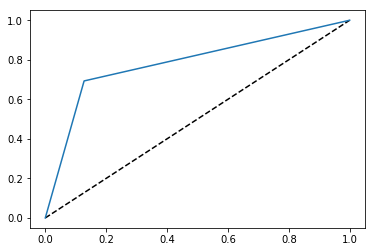

In [36]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm)

### Cross vallidation to get best model

In [31]:
scores = cross_validation.cross_val_score(lr, training_data[features_wo_minor], training_data['Survived'], cv=3)
print("Score Result: " + str(scores))
print("Average Score: " + str(scores.mean()))

Score Result: [ 0.79461279  0.79461279  0.79124579]
Average Score: 0.793490460157


In [32]:
features_w_minor = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title', 'IsMinor']

In [33]:
scores = cross_validation.cross_val_score(lr, training_data[features_w_minor], training_data['Survived'], cv=3)
print("Score Result: " + str(scores))
print("Average Score: " + str(scores.mean()))

Score Result: [ 0.7979798   0.79461279  0.79461279]
Average Score: 0.795735129068


Let us finalize the features

In [34]:
selected_features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title', 'IsMinor' ]

### 4.0 Train and evaluate the model

In [35]:
from sklearn.grid_search import GridSearchCV
import numpy as np

In [36]:
params = {'C': np.arange(1e-05, 3, 0.1)}

In [37]:
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc'}

In [39]:
gs = GridSearchCV(LogisticRegression(),
                  param_grid=params)

In [40]:
gs.fit(training_data[selected_features], training_data['Survived'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.00010e-01,   2.00010e-01,   3.00010e-01,
         4.00010e-01,   5.00010e-01,   6.00010e-01,   7.00010e-01,
         8.00010e-01,   9.00010e-01,   1.00001e+00,   1.10001e+00,
         1.20001e+00,   1.30001e+00,   1.40001e+00,   1.50001e+00,
         1.6000...    2.40001e+00,   2.50001e+00,   2.60001e+00,   2.70001e+00,
         2.80001e+00,   2.90001e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [41]:
print("Best score: %s" % (gs.best_score_))
print("Best parameter set: %s" % (gs.best_params_))

Best score: 0.796857463524
Best parameter set: {'C': 0.50000999999999995}


### 5. Deploy the model

Now that we have a well trained model, we can deploy that in a production environment to be used the end users or applications. 

Here, I will be using IBM Watson Machine Learning Service to deploy a trained model as a ReST service.

##### IBM WML Service Credentials

In [42]:

wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "Uxormn3AYG5S67ZzJswnXa6XkpFABZZjGmW5+JPCGfse4LYXIMYHcSzrY2IDbVPPHxGxQ3pIogjgEOjN0TGDTcL0h32gVzPkwMbmHXNpi+FQYUqQmv73SQJrb1WXWeZv",
  "username": "5e8e8378-fb80-4a44-a7c8-820fa986d988",
  "password": "ecc5b773-40da-4722-9531-32cad7be27f5",
  "instance_id": "a91c300c-460b-4ebb-903f-992be2898028"
}



#### 5.1. Save the model to WML Repository

Inorder to deploy the model in WML service, the model has to be saved in the WML Repository. We will be using WML's Python client for this purpose.

In [43]:
from repository_v3.mlrepository import MetaNames
from repository_v3.mlrepository import MetaProps
from repository_v3.mlrepositoryclient import MLRepositoryClient
from repository_v3.mlrepositoryact import MLRepositoryArtifactrtifa

import pprint

Initialize the watson_machine_learning_client

In [45]:
ml_repository_client = MLRepositoryClient(wml_credentials['url'])
ml_repository_client.authorize(wml_credentials['username'], wml_credentials['password'])

The code below uploads the saved model's compressed tar ball in WML Repository. The API returns a bunch of metadata that was created as part of saving the model.

In [46]:
props_meta = MetaProps({MetaNames.AUTHOR_NAME:"Krishna", MetaNames.AUTHOR_EMAIL:"krishna@in.ibm.com"})

In [48]:
model_artifact = MLRepositoryArtifact(gs, name='titanic_survival_prediction', meta_props=props_meta)
saved_model = ml_repository_client.models.save(model_artifact)


In [50]:

saved_model_details = saved_model.meta.get()
print("Model GUID: " + saved_model.uid )
pprint.pprint(saved_model_details)


Model GUID: ed71ad09-6c48-4adc-9326-40bd89f445c2
{'authorEmail': 'krishna@in.ibm.com',
 'authorName': 'Krishna',
 'contentStatus': {'state': 'no_content'},
 'creationTime': datetime.datetime(2018, 2, 3, 7, 25, 1, 58000, tzinfo=tzutc()),
 'frameworkName': 'scikit-learn',
 'frameworkVersion': '0.17',
 'modelVersionUrl': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/ed71ad09-6c48-4adc-9326-40bd89f445c2/versions/b420aa60-aa43-4540-bc9c-c16907f21907',
 'runtimes': [{'name': 'python', 'version': '3.5'}],
 'version': 'b420aa60-aa43-4540-bc9c-c16907f21907'}


#### 5.2 Deploy the model

In [51]:

import urllib3
import time
import base64
import requests
import json
import pprint
import numpy as np

##### 5.2.1 Generate token 

In [52]:
headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(wml_credentials['username'], wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

Get published_models url from instance details

In [53]:
endpoint_instance = wml_credentials['url'] + "/v3/wml_instances/" + wml_credentials['instance_id']
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken} 

response_get_instance = requests.get(endpoint_instance, headers=header)
print(response_get_instance)
print(response_get_instance.text)

<Response [200]>
{"metadata":{"guid":"a91c300c-460b-4ebb-903f-992be2898028","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/a91c300c-460b-4ebb-903f-992be2898028","created_at":"2017-08-31T14:26:54.068Z","modified_at":"2017-08-31T14:26:54.068Z"},"entity":{"source":"Bluemix","published_models":{"url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/a91c300c-460b-4ebb-903f-992be2898028/published_models"},"usage":{"expiration_date":"2018-03-01T00:00:00.000Z","computation_time":{"limit":18000,"current":0},"model_count":{"limit":200,"current":4},"prediction_count":{"limit":5000,"current":1},"deployment_count":{"limit":5,"current":5}},"plan_id":"3f6acf43-ede8-413a-ac69-f8af3bb0cbfe","status":"Active","organization_guid":"95b08930-8750-46fe-9263-a7c764db67c0","region":"us-south","account":{"id":"500387184","name":"KRISHNAMURTHY ARTHANARISAMY's Account","type":"TRIAL"},"owner":{"ibm_id":"270000CB8X","email":"krishnamurthy.a@in.ibm.com","user_id":"6d8e945b-c86f-4de4-9b42-72df78f9

In [54]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')
print("Published models url: " + endpoint_published_models)


Published models url: https://ibm-watson-ml.mybluemix.net/v3/wml_instances/a91c300c-460b-4ebb-903f-992be2898028/published_models


Get deployment URL of the saved model

In [55]:
response_models = requests.get(endpoint_published_models, headers=header)
[deployment_url] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_models.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]
print(deployment_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/a91c300c-460b-4ebb-903f-992be2898028/published_models/ed71ad09-6c48-4adc-9326-40bd89f445c2/deployments


Prepare payload for deploying the model

In [56]:
payload_online = {"name": "titanic_surv_prediction", "type": "online"}
response_online = requests.post(deployment_url, json=payload_online, headers=header)


Submit request for deployment

In [57]:
print("Response Code: " + str(response_online.status_code))
pprint.pprint(response_online.content)

Response Code: 402
(b'{"trace":"gtfo5vs9csin","errors":[{"code":"deployments_plan_limit_reached","'
 b'message":"Current plan \'lite\' only allows 5 deployments"}]}')


### 6.0 Predictions based on deployed model

###### 6.1 Get input data for scoring from test data 

In [70]:
test_data = get_test_data(complete_data_df)[selected_features]

In [71]:
input_for_prediction = test_data.values[np.random.randint(test_data.shape[0])]

In [72]:
input_for_prediction = input_for_prediction.tolist()

In [73]:
input_for_prediction

[48.0, 0.0, 106.425, 0.0, 1.0, 0.0, 1.0, 13.0, 0.0]

###### 6.2 Prepare JSON paylod for scoring

In [74]:
payload_scoring = { "values": [input_for_prediction] }

###### 6.3 Get URL for scoring request from deployment's response

In [75]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/a91c300c-460b-4ebb-903f-992be2898028/published_models/24f21bfb-8bd2-4a39-8aa5-533a717e7d91/deployments/d0bad8ec-8c34-4830-ae2a-6fd025877b83/online


In [76]:
response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header)
pprint.pprint(response_scoring.text)

'{"values":[[1,[0.10013441850322513,0.8998655814967749]]],"fields":["prediction","probability"]}'


### 7.0 References

Kaggle Titanic - Machine Learning from Disaster: https://www.kaggle.com/c/titanic <br>
IBM Data Science Experience: https://datascience.ibm.com/ <br>
IBM Bluemix: https://console.bluemix.net/ <br>